In [40]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [41]:
startDate<-'1997-01-01'
endDate<-'2017-05-31'

nifty<-sqlQuery(lcon, sprintf("select TIME_STAMP, PX_CLOSE FROM BHAV_INDEX WHERE INDEX_NAME='NIFTY 50' AND TIME_STAMP >='%s' AND TIME_STAMP <= '%s'", startDate, endDate))
nXts<-xts(nifty[,-1], as.Date(nifty[,1]))
nRets<-dailyReturn(nXts)

startYear<-as.numeric(format(min(as.Date(index(nRets))), "%Y"))+1
endYear<-as.numeric(format(max(as.Date(index(nRets))), "%Y"))-1

retsByDay<-data.frame(DAY=NA, RET=NA, stringsAsFactors = F)
for(yr in startYear:endYear){
    for(mo in 1:12){
        moRange<-nRets[sprintf("%d-%d", yr, mo),]
        for(i in 1:length(moRange[,1])){
            retsByDay<-rbind(retsByDay, c(i, as.numeric(moRange[i,1])))
        }
    }
}

retsByDay<-na.omit(retsByDay)
summaries<-data.frame(DAY=NA, MEAN=NA, MEDIAN=NA, SD=NA, stringsAsFactors = F)
for(i in 1:max(retsByDay[,1])){
    dayRange<-retsByDay[which(retsByDay$DAY==i),2]
    summaries<-rbind(summaries, c(i, mean(dayRange), median(dayRange), sd(dayRange)))
}

summaries<-na.omit(summaries)


Warning message:
“closing unused RODBC handle 9”

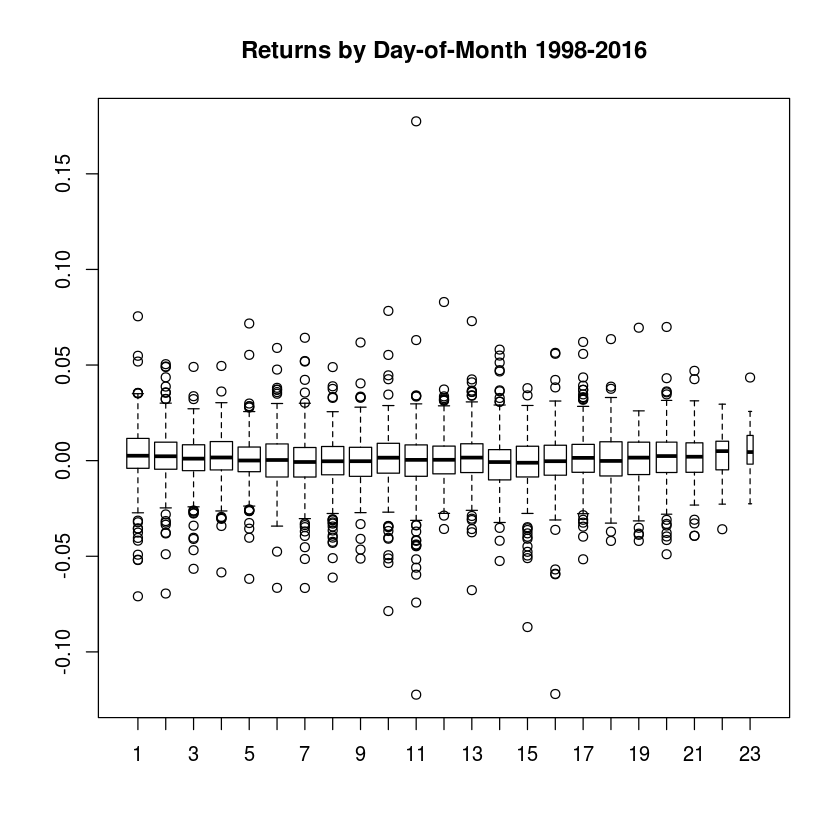

In [42]:
boxplot(RET~DAY, data=retsByDay, varwidth=TRUE, horizontal=F, main=sprintf('Returns by Day-of-Month %d-%d', startYear, endYear))


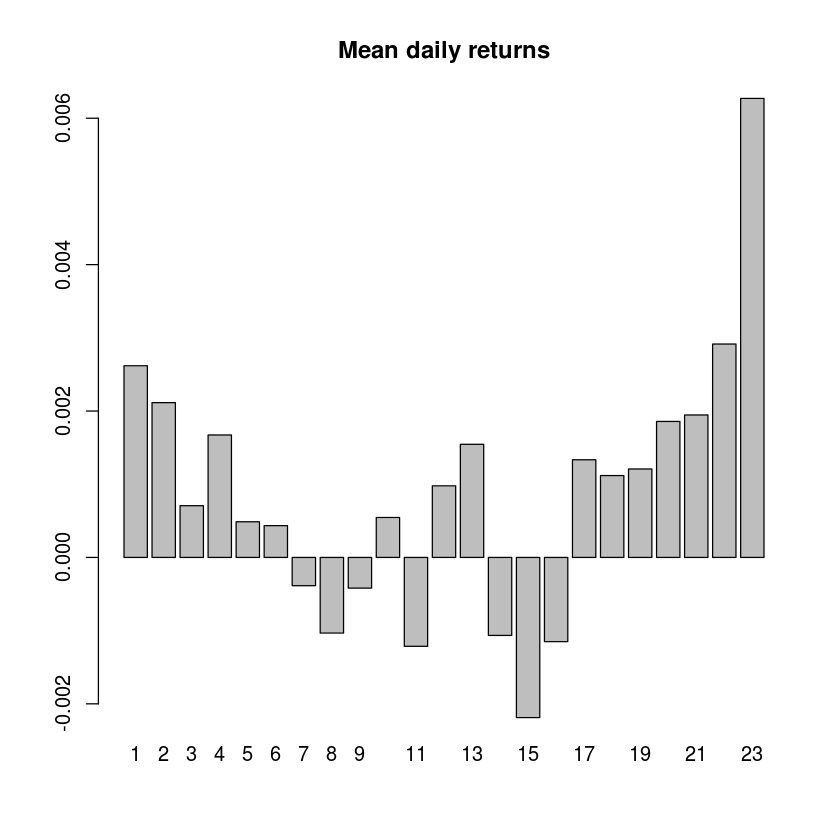

In [43]:
barplot(summaries[,2], main='Mean daily returns', names.arg=summaries[,1])

The first and the last few days of the month always see a bump...

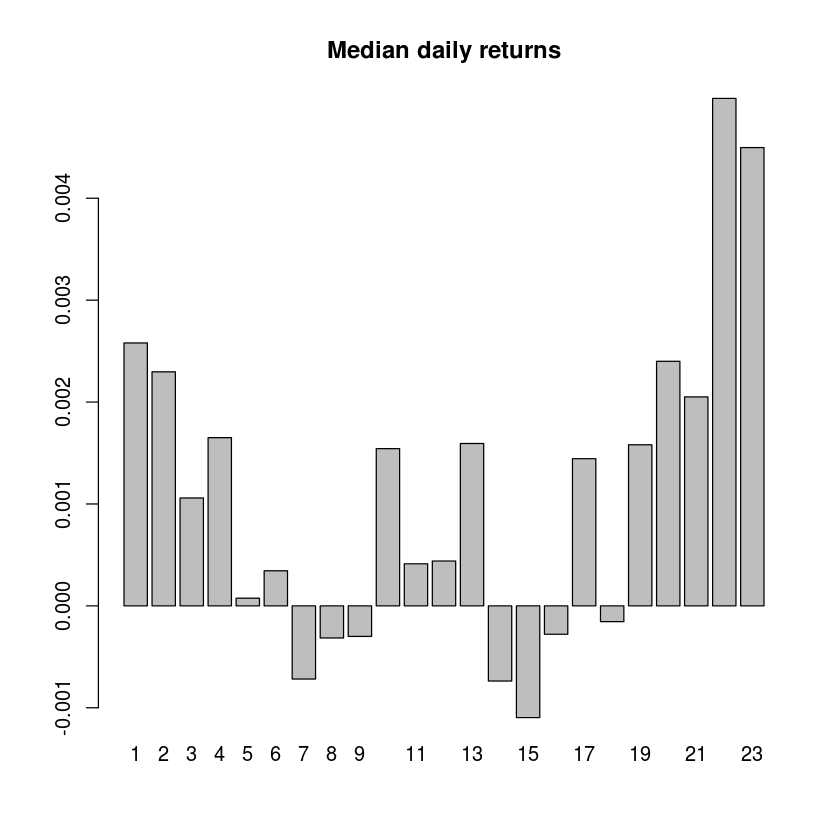

In [44]:
barplot(summaries[,3], main='Median daily returns', names.arg=summaries[,1])

Should we prefer buying in the middle of the month over other days?

In [57]:
sipByDay<-data.frame(DAY=NA, UNITS=NA, DATE=NA, stringsAsFactors = F)
for(yr in startYear:endYear){
    for(mo in 1:12){
        moRange<-nXts[sprintf("%d-%d", yr, mo),]
        sipByDay<-rbind(sipByDay, c(1, 1000.0/as.numeric(first(moRange)), toString(index(first(moRange)))))
        iMid<-as.integer(length(moRange[,1])/2)
        sipByDay<-rbind(sipByDay, c(15, 1000.0/as.numeric(moRange[iMid]), toString(index(moRange[iMid]))))
        sipByDay<-rbind(sipByDay, c(23, 1000.0/as.numeric(last(moRange)), toString(index(last(moRange)))))
    }
}
sipByDay<-sipByDay[-1,]

#head(sipByDay)
#tail(sipByDay)

sipByDay$UNITS<-as.numeric(sipByDay$UNITS)
sipByDay$DAY<-as.numeric(sipByDay$DAY)

sprintf("Total Units #First: %.2f", sum(sipByDay[sipByDay$DAY==1,]$UNITS))
sprintf("Total Units #Mid: %.2f", sum(sipByDay[sipByDay$DAY==15,]$UNITS))
sprintf("Total Units #Last: %.2f", sum(sipByDay[sipByDay$DAY==23,]$UNITS))

[1] "Total Units #First: 102.07"

[1] "Total Units #Mid: 101.53"

[1] "Total Units #Last: 101.47"

Buying in the middle of the month doesn't yeild in better returns. The day-of-the-month analysis uses daily returns - the dip in the middle of the month is returns over the previous day.